In [247]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import statistics

По полученным массивам кардиоинтервалов рассчитать основные параметры
вариабельности: среднее значение M, среднеквадратическое отклонение SDNN,
коэффициент вариации CV и среднеквадратическую разностную характеристику
RMSSD.


In [248]:
df = pd.read_csv('Data/4_f_1.csv', header=None)
df

,0
0,866
1,927
2,924
3,892
4,897
...,...
295,842
296,829
297,806
298,883


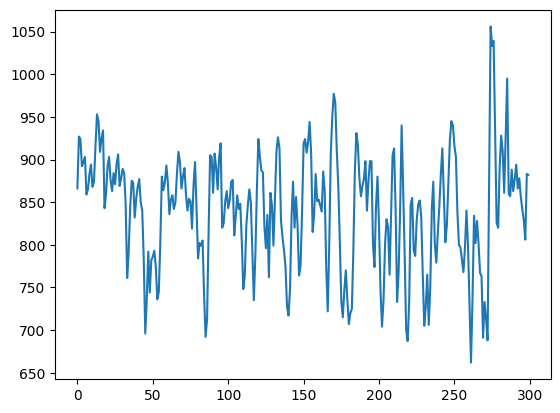

In [249]:
plt.plot(df.index,df)
plt.show()

# Исследование общей вариабельности сердечного ритма

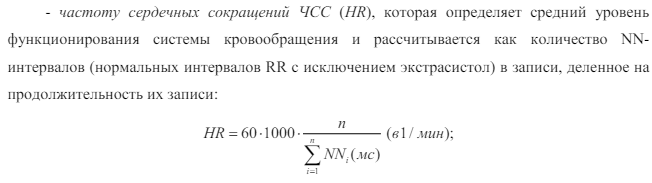

In [250]:
HR = 60 * 1000 * len(df[0]) / df[0].sum()
HR

71.40986884387422

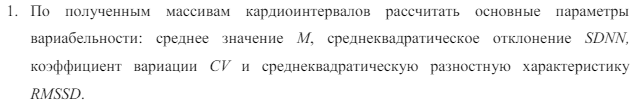

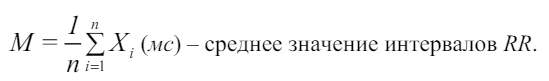

In [251]:
M = df[0].mean()
M

840.22

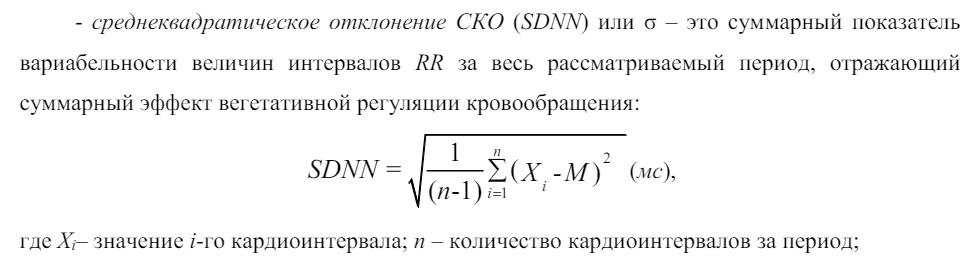

In [252]:
SDNN = df[0].std(ddof = 0)
SDNN

66.71075575447585

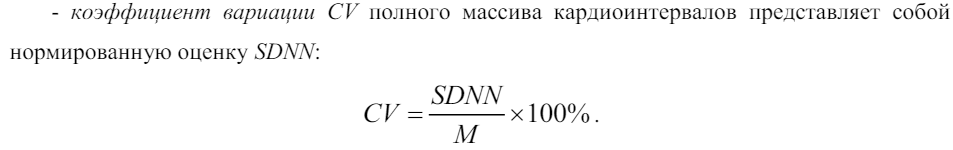

In [253]:
CV = SDNN / M * 100
CV

7.939677198171413

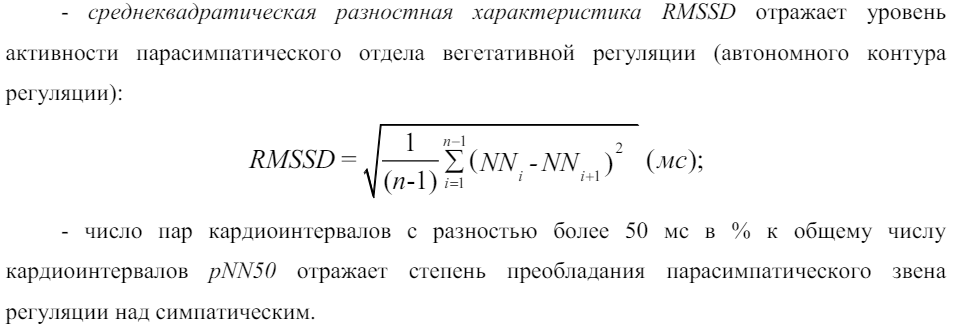

In [254]:
temp = np.array(df[0])
sum = 0
for i in range(len(temp)-1):
  sum += np.power((temp[i+1] - temp[i]), 2)

RMSSD = np.sqrt(sum / (len(temp) - 1))
RMSSD

47.813741185498614

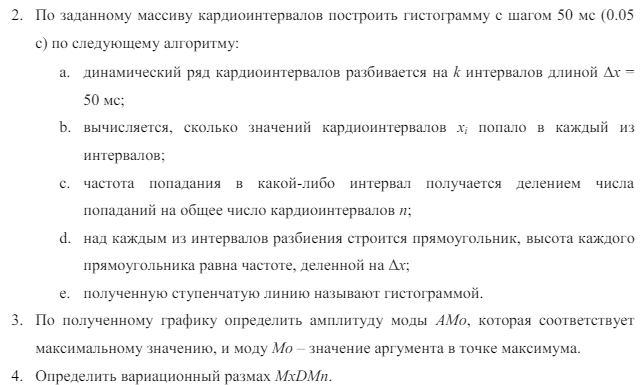

In [255]:
dx = 50
k = len(temp) / dx
Mn = np.min(temp)
Mx = np.max(temp)
MxDMn = Mx - Mn
k = math.ceil(MxDMn / 50)

# на практике берут 400 - 1300
borders = np.arange(400, 1300, 50)

print('Mn', Mn)
print('Mx', Mx)
print('MxDMn', MxDMn)
print('k', k)

Mn 662
Mx 1056
MxDMn 394
k 8


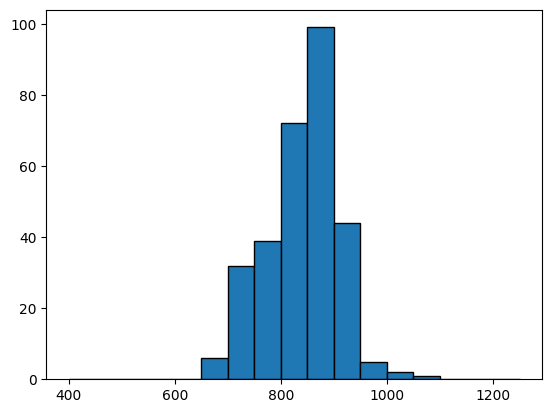

In [256]:
n , bins, patches = plt.hist(temp, bins=borders, edgecolor='black')

In [257]:
n.max()

99.0

0.32999999999999663

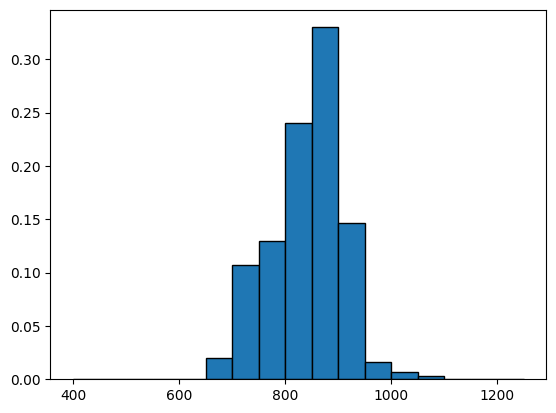

In [258]:
n , bins, patches = plt.hist(temp, bins=borders, edgecolor='black', weights=np.ones_like(temp) / len (temp))
n_max = n.max()
n_max

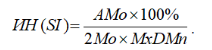

Mo = [850:900] = (900 + 950) / 2 = 925  

In [259]:
Amo = n_max
Mo = 0.875
#MxDMn = 850 - 600
SI = Amo * 100 / (2 * Mo * MxDMn / 1000)
SI

47.86076867295093

In [260]:
print('HR:', HR)
print('M:', M)
print('SDNN:', SDNN)
print('CV:', CV)

print('Amo:', Amo)
print('Mo:', Mo)
print('MxDMn:', MxDMn)
print('SI:', SI)

HR: 71.40986884387422
M: 840.22
SDNN: 66.71075575447585
CV: 7.939677198171413
Amo: 0.32999999999999663
Mo: 0.875
MxDMn: 394
SI: 47.86076867295093


Вывод: СКО и RMSSD находится в норме, а вот ИН находится ниже нормы, что говорит от том, что степень преобладания активности центральных механизмов регуляции над автономными склоняется к автономным, т.е. человек достаточно спокоен.


# Исследование внутренней организации динамического ряда кардиоинтервалов

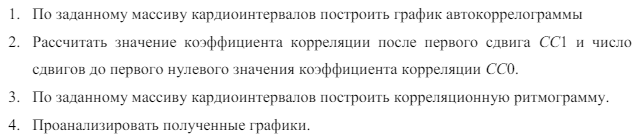

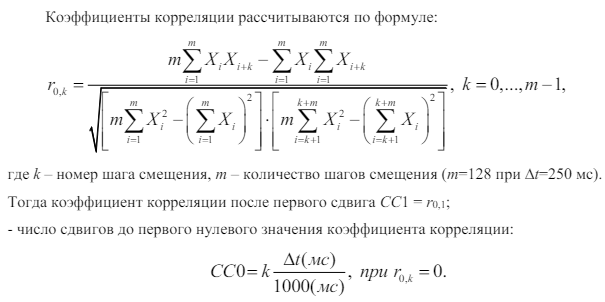

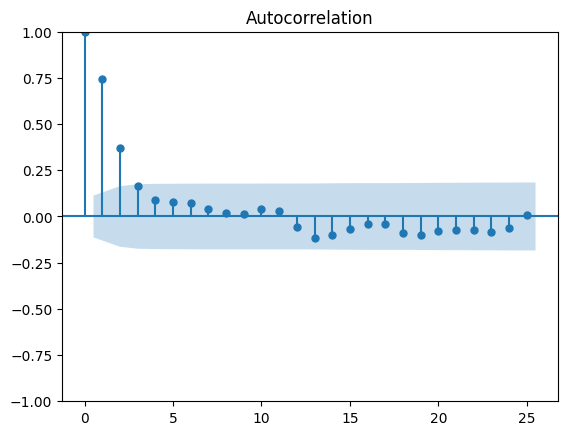

In [261]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df[0])
plt.show()

In [262]:
from statsmodels.tsa.stattools import acf

acfs = acf(df[0])

acfs

array([ 1.        ,  0.74310109,  0.37093467,  0.16565374,  0.08828709,
        0.07942176,  0.07282191,  0.04209643,  0.01953866,  0.01221132,
        0.0408916 ,  0.02881097, -0.05963502, -0.1160643 , -0.09769919,
       -0.06637702, -0.04311809, -0.0381235 , -0.0873401 , -0.10186865,
       -0.07644553, -0.07192376, -0.07457021, -0.08620682, -0.06449621])

In [263]:
for i in range(len(acfs)):
  if acfs[i] <= 0:
    CC0 = i
    break

print('Значение коэффициента корреляции после первого сдвига СС1 =', acfs[1])
print('Число сдвигов до первого нулевого значения коэффициента корреляции  СС0 =', CC0)

Значение коэффициента корреляции после первого сдвига СС1 = 0.7431010892178449
Число сдвигов до первого нулевого значения коэффициента корреляции  СС0 = 12


Корреляционная ритмограмма - скаттерограмма

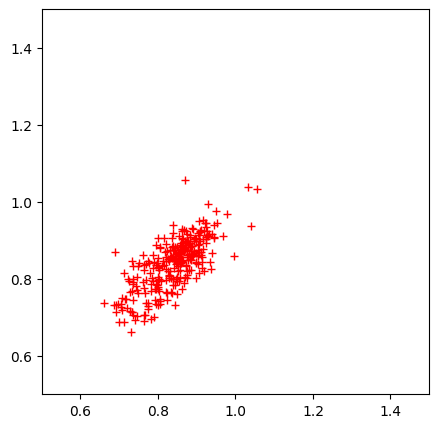

In [264]:
n = len(df[0])
plt.figure(figsize=(5,5))
plt.plot(df[0][0:n-1]/1000,df[0][1:n]/1000,'r+')
plt.xlim(0.5, 1.5)
plt.ylim(0.5, 1.5)
plt.show()

Вывод:
Так как коэффициент корреляции после первого сдвига лишь незначительно ниже единицы (на 0.25), значит доминируют медленноволновые компоненты).  
По скаттерограмме все группируется в один овал длиной примерно 0.4, который соответствует вариационному размаху. Можно сказать, что скаттерограмма имеет нормальную форму.

# Спектральный анализ вариабельности сержечного ритма

In [265]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
import numpy as np
from scipy.fftpack import rfft, fft, ifft, fftshift
import scipy.signal as sig

In [266]:
data = pd.read_csv('4_f_1.csv', names = ['RR'])
RR = data.RR
RR

0      866
1      927
2      924
3      892
4      897
      ... 
295    842
296    829
297    806
298    883
299    882
Name: RR, Length: 300, dtype: int64

300


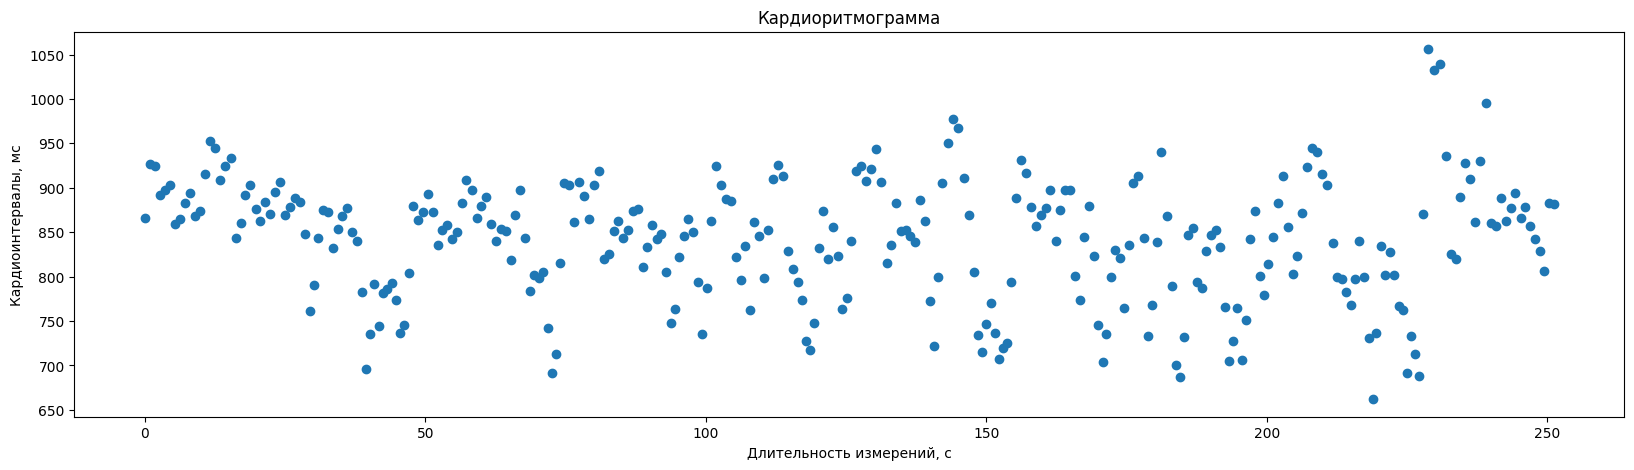

In [267]:
signal = np.array(RR)
print(len(signal))
time_x = [0]
for i in range(0,len(signal)-1):
    time_x.append(signal[i]/1000+time_x[i])
plt.figure(figsize=(20, 5))
plt.plot(time_x, signal, 'o')
plt.title('Кардиоритмограмма')
plt.ylabel('Кардиоинтервалы, мс')
plt.xlabel('Длительность измерений, с')
plt.show()

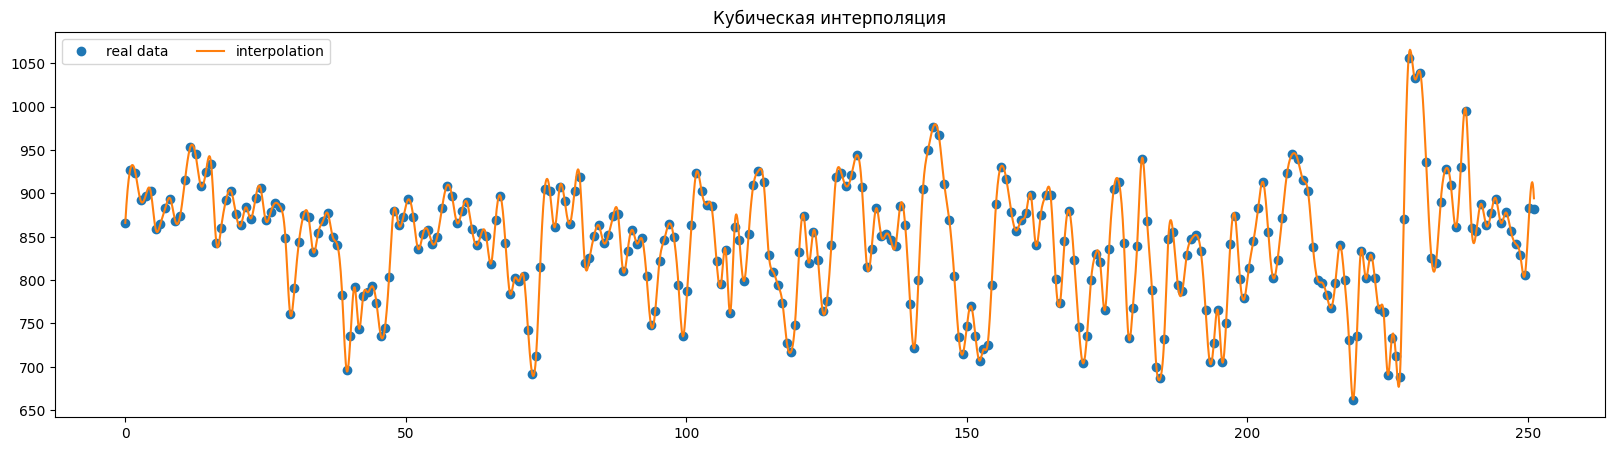

In [268]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(time_x, signal)
xs = np.arange(0, max(time_x), 0.1)
# time = np.array([i * max(time_x)/len(time_x) for i in range(len(time_x))])
plt.figure(figsize=(20, 5))
plt.title('Кубическая интерполяция')
plt.plot(time_x, signal, 'o', label='real data')
plt.plot(xs, cs(xs), label="interpolation")
plt.legend(ncol=2)
plt.show()

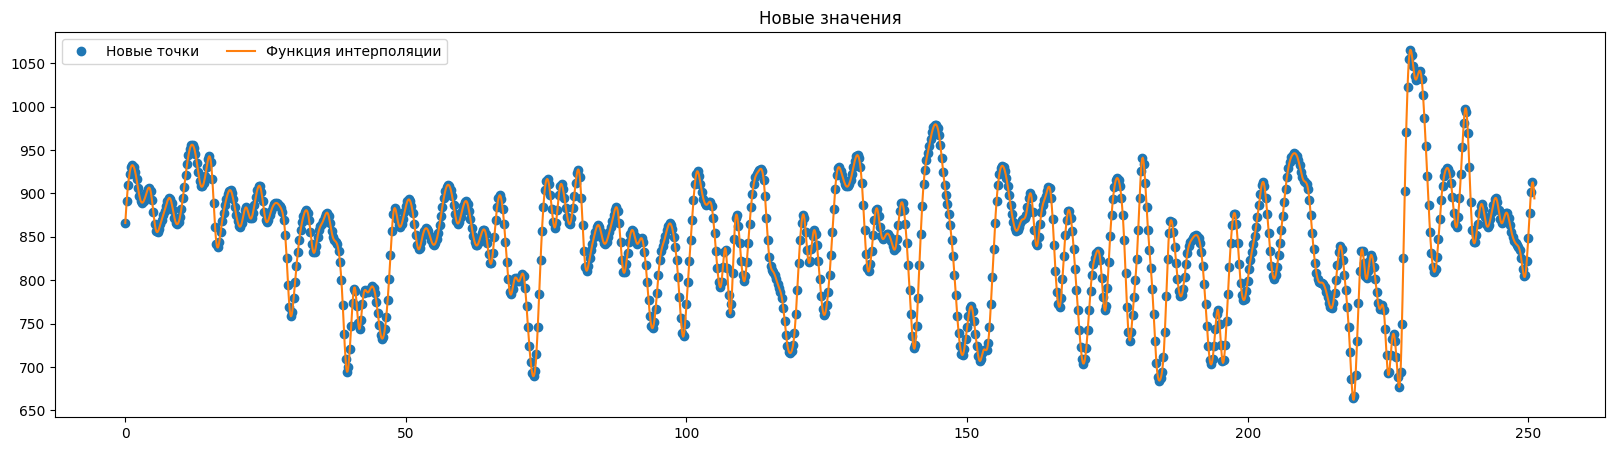

In [269]:
max_time = int(max(time_x))
delta = 0.25
scale = 1/delta
n_batch = int(max_time*scale/2)
time = np.array([float(i)*delta for i in range(int(n_batch*2))])
values = cs(time)
plt.figure(figsize=(20, 5))
plt.title('Новые значения')
plt.plot(time, values, 'o', label="Новые точки")
plt.plot(xs, cs(xs), label="Функция интерполяции")
plt.legend(ncol=2)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


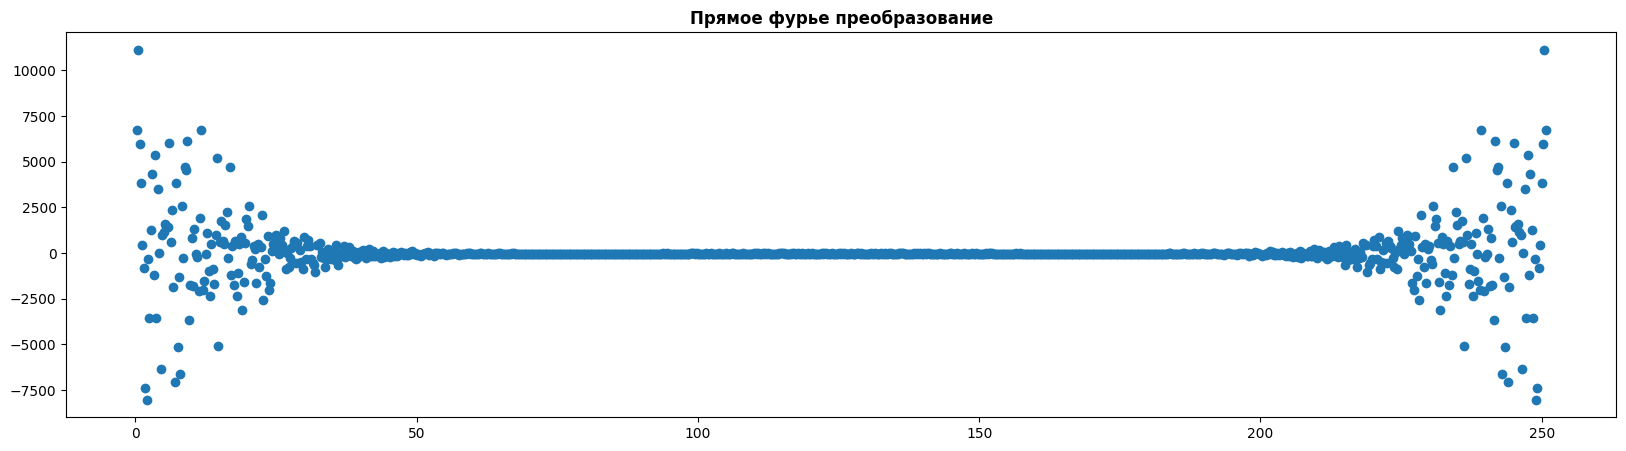

In [270]:
from scipy.fft import fft


sample_fourier = fft(values, n=2*n_batch)
plt.figure(figsize=(20, 5))
plt.title("Прямое фурье преобразование", fontweight="bold")
plt.plot(time[1:], sample_fourier[1:], 'o')
plt.show()

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# from here https://stackoverflow.com/a/16445006/4999991
def polarToRectangular(radii, angles):
    return radii * np.exp(1j * angles)

def sortZip(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    return xs, ys

def plotSort(x, y):
    xs, ys = sortZip(x, y)
    plt.plot(xs, ys)

def frequencyGenerator(time, steps=None):
    𝛿 = time.max() - time.min()
    if steps is None:
        steps = int(𝛿 / np.diff(time).mean() / 2) # or np.diff(time).min()
    M = np.arange(1, steps + 1)
    return M / 𝛿, steps

def easyFourierTransform(time, signal, frequency=None, steps=None, sorted=False, uniform=False):
    if sorted:
        ts = time
        Xs = signal
    else:
        ts, Xs = sortZip(time, signal)

    if frequency is None:
        frequency, steps = frequencyGenerator(ts, steps)
    else:
        steps = frequency.shape[0]
#     print(frequency)

    if uniform:
        N = signal.shape[0]
        amplitude = np.abs(scipy.fftpack.fft(signal)[:steps]) * 2.0 / N
    else:
        ft = frequency[:, np.newaxis]
        𝜃 = (ts - ts.min()) * 2 * np.pi * ft
        Y = polarToRectangular(Xs, 𝜃)[:, 1:] * np.diff(ts)
        amplitude = np.abs(Y.sum(axis=1))
    return frequency, amplitude

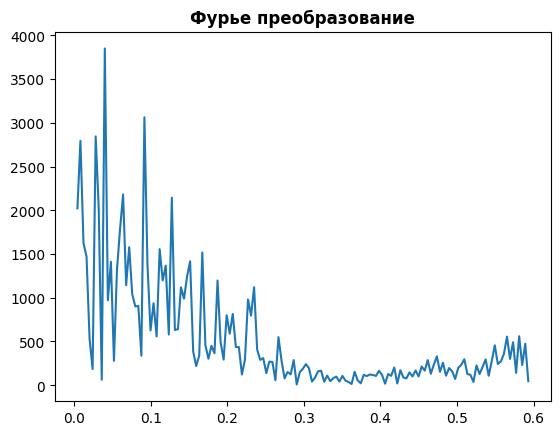

In [272]:
freq, sample_fourier = easyFourierTransform(time_x, signal)
plt.plot(freq, sample_fourier)
plt.title("Фурье преобразование", fontweight="bold")
n_batch=len(freq)

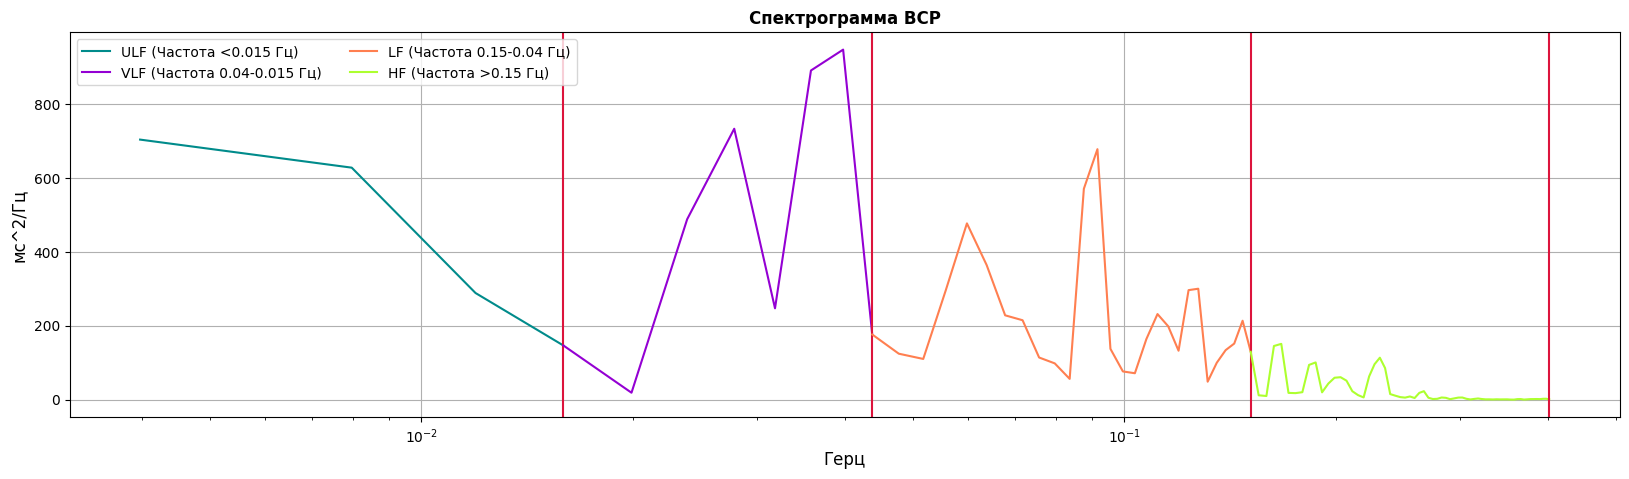

In [273]:
##Не забудем нормировать умножением на sqrt(2)
sample_fourier *= math.sqrt(2)


labels = ['HF', 'LF', 'VLF', 'ULF']
borders_freq = [float('+inf'), 0.4, 0.15, 0.04, 0.015, 0]
borders_times = [2.5, 25, 66]

# Посчитаем мощность
final_values = np.array(abs(np.power(sample_fourier, 2)/(n_batch**2)))
final_values = [val.real for val in final_values]
# final_values = final_values[n_batch:2*n_batch]
final_values = final_values[0*n_batch:1*n_batch]
final_values[0] = final_values[1]

# линейное усреднение Pl по сегментам.
# усредню по соседям (если не так, то несложно переделать)
final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[1:n_batch-1])
final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[2:n_batch])
final_values[1:n_batch-1]/=np.ones(len(final_values)-2)*3

labels = labels[::-1]
borders_freq = borders_freq[::-1]

part = 0
final_vals = [[]]
final_freq = [[]]
for h, v in zip(freq, final_values):
#     print(h)
    if h > borders_freq[part+1]:
        final_freq[part].append(h)
        final_vals[part].append(v)
        part+=1
        final_freq.append([])
        final_vals.append([])
    final_freq[part].append(h)
    final_vals[part].append(v)

plt.figure(figsize=(20, 5))
colors = ['darkcyan','darkviolet','coral','greenyellow']
labels = ['ULF (Частота <0.015 Гц)', 'VLF (Частота 0.04-0.015 Гц)', 'LF (Частота 0.15-0.04 Гц)', 'HF (Частота >0.15 Гц)']
for val, h, col, lab in zip(final_vals, final_freq, colors, labels):
    plt.plot(h, val, color = col, label = lab)
    plt.axvline(x=h[-1], color = 'crimson')
plt.grid()
x_label = plt.xlabel('Герц', fontsize=12)
y_label = plt.ylabel('мс^2/Гц', fontsize=12)
title = plt.title('Спектрограмма ВСР', fontweight="bold")
plt.xscale(value='log')
plt.legend(ncol=2)
plt.show()

In [274]:
f_max = []
f_min = []
power = []
for l in final_vals:
    f_max.append(np.max(l))
    f_min.append(np.min(l))
    power.append(np.sum(l))
total = np.sum(power)
print(f'Суммарная мощность спектра ВСР = {total}')
for mx, mn, pw, lab in zip(f_max, f_min, power, labels):
    print(f'В диапазоне {lab}:\n\t* Максимальное значение плотности мощности = {mx}'+
            f'\n\t* Минимальное значение плотности мощности = {mn}'+
            f'\n\t* Мощность = {pw}, что составляет {pw/total*100}% общей мощности')

Суммарная мощность спектра ВСР = 13149.60471668401
В диапазоне ULF (Частота <0.015 Гц):
	* Максимальное значение плотности мощности = 703.5264566402382
	* Минимальное значение плотности мощности = 146.57681246304617
	* Мощность = 1766.2049225528667, что составляет 13.431619889774588% общей мощности
В диапазоне VLF (Частота 0.04-0.015 Гц):
	* Максимальное значение плотности мощности = 946.9462279450081
	* Минимальное значение плотности мощности = 18.739262845984058
	* Мощность = 3647.1859487376996, что составляет 27.73608809784379% общей мощности
В диапазоне LF (Частота 0.15-0.04 Гц):
	* Максимальное значение плотности мощности = 677.6582016855538
	* Минимальное значение плотности мощности = 48.59369531984576
	* Мощность = 5893.376885444379, что составляет 44.81790146868031% общей мощности
В диапазоне HF (Частота >0.15 Гц):
	* Максимальное значение плотности мощности = 150.96665171240417
	* Минимальное значение плотности мощности = 0.09413576489112951
	* Мощность = 1491.9593108888735, ч

In [275]:
n_to_i = {'HF':0, 'LF':1, 'VLF':2, 'ULF':3}
IC = (power[n_to_i['VLF']] + power[n_to_i['LF']])/power[n_to_i['HF']]
IVV = (power[n_to_i['LF']])/power[n_to_i['HF']]
ISCA = (power[n_to_i['LF']])/power[n_to_i['VLF']]
print('Индексы:')
print(f'\t* индекс централизации ИЦ (IC): {IC}\n'+
      f'\t* индекс вагосимпатического взаимодействия ИВВ: {IVV}\n'+
      f'\t* индекс активации подкорковых нервных центров ИАП (ISCA): {ISCA}')

Индексы:
	* индекс централизации ИЦ (IC): 5.401730406453731
	* индекс вагосимпатического взаимодействия ИВВ: 2.064984590500444
	* индекс активации подкорковых нервных центров ИАП (ISCA): 0.6188618205880602


Вывод

Была построена спектрорграмма мощности ВСР а также определены мощности отдельных участков спектрорграммы мощности ВСР.   
HF 11.3 % находится вне нормы 15-25% и говорит о преобладании симпатической активности.  
LF 44.8 находится за пределами нормы в 15-40%, что говорит о большем преобладании симпатического отдела.  
VLF находится в норме.
Расчитаны индекс централизации ИЦ (IC), индекс вагосимпатического взаимодействия ИВВ и индекс активации подкорковых нервных центров ИАП (ISCA). ИВВ = 2.06, так что можно сказать что симпатическая система преобладает.

# Комплексная оценка функционального состояния

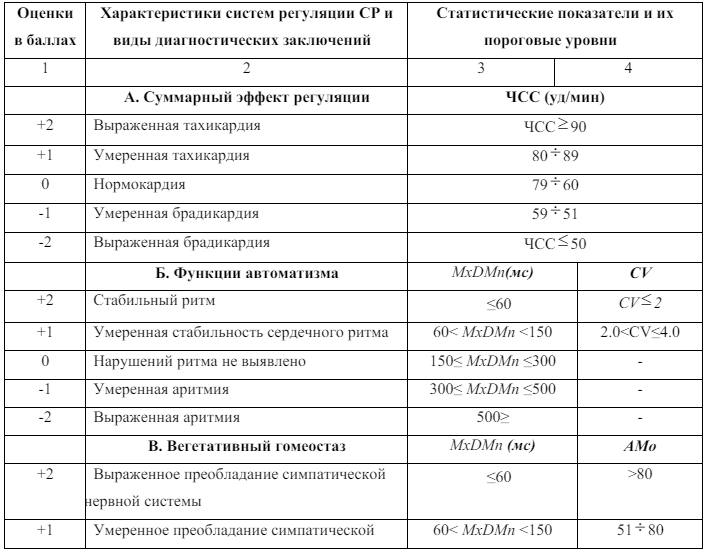

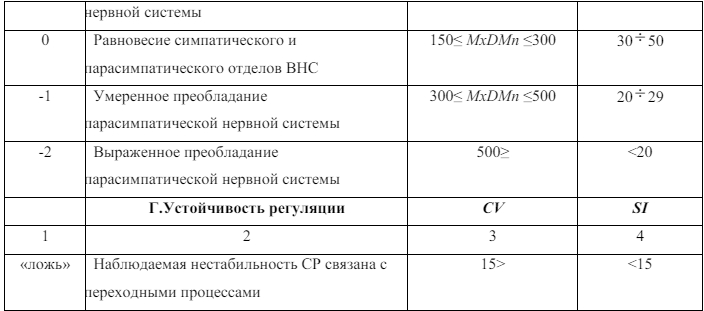

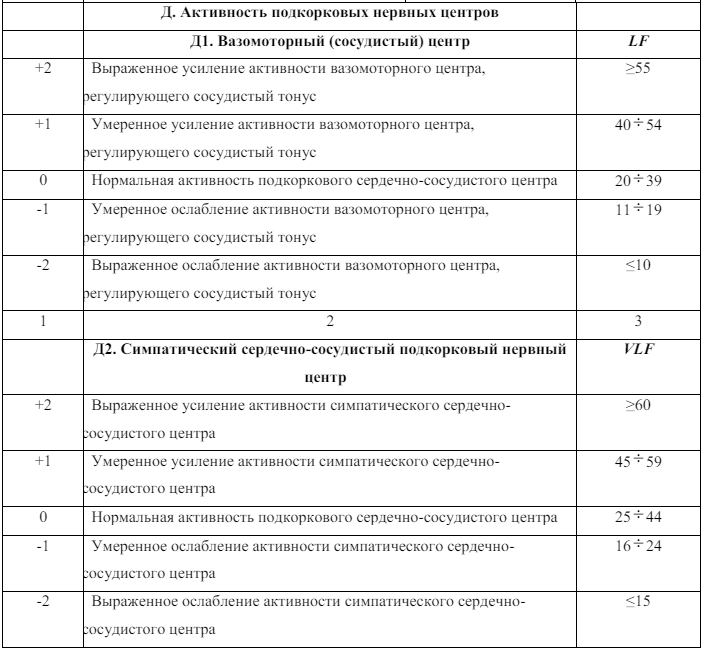

ЧСС = 71 = 0 баллов (нормокардия)  
MxDMn = 394 = -1 балл (умеренная аритмия) и -1 балл (умеренное преобладание парасимпатической нервной системы)  
CV = 7.93 % = ? баллов  
AMO = 0.33 = 0 балл (Равновесие симпатического и парасимпатического отделов ВНС)  
LF = 44.8 = +1 балл (умеренное усиление активности вазомоторного центра регулирующего сосудистый тонус)   
VLF = 27.7 = 0 (Нормальная активность подкоркового сердечно-сосудистого центра)  
Если проссумировать баллы и взять модуль, То получится ПАРС = 1, что соответствует состоянию оптимального (рабочего) напряжения регуляторных систем,
необходимого для поддержания активного равновесия организма со средой.   
